In [3]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as sc
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from qlr import QuantileLinearRegression

import os

In [4]:
def elapsedtime_to_sec(el):
    tab = el.split(":")
    return float(tab[0])*60+float(tab[1])
#because x264 output is "m:s", where m is the number of minutes and s the number of seconds 

res_dir = "../../data/res_ugc/"

v_names = sorted(os.listdir(res_dir)) # so we keep the same ids between two launches

listVideo = []

for v in v_names:
    data = pd.read_table(res_dir+v, delimiter = ',')
    data['etime'] = [*map(elapsedtime_to_sec, data['elapsedtime'])]
    assert data.shape == (201,36) or data.shape == (201,34), v
    listVideo.append(data)

In [5]:
#our variable of interest
predDimension = "etime"

# RQ1 - Input sensitivity

## RQ1.1 - Do the same options have the same effect on all inputs?

In [6]:
nbVideos = len(listVideo)
corrSpearman= [[0 for x in range(nbVideos)] for y in range(nbVideos)]

for i in range(nbVideos):
    for j in range(nbVideos):
        if (i == j):
            corrSpearman[i][j] = 1
        else:
            corrSpearman[i][j] = sc.spearmanr(listVideo[i][predDimension],
                                            listVideo[j][predDimension]).correlation

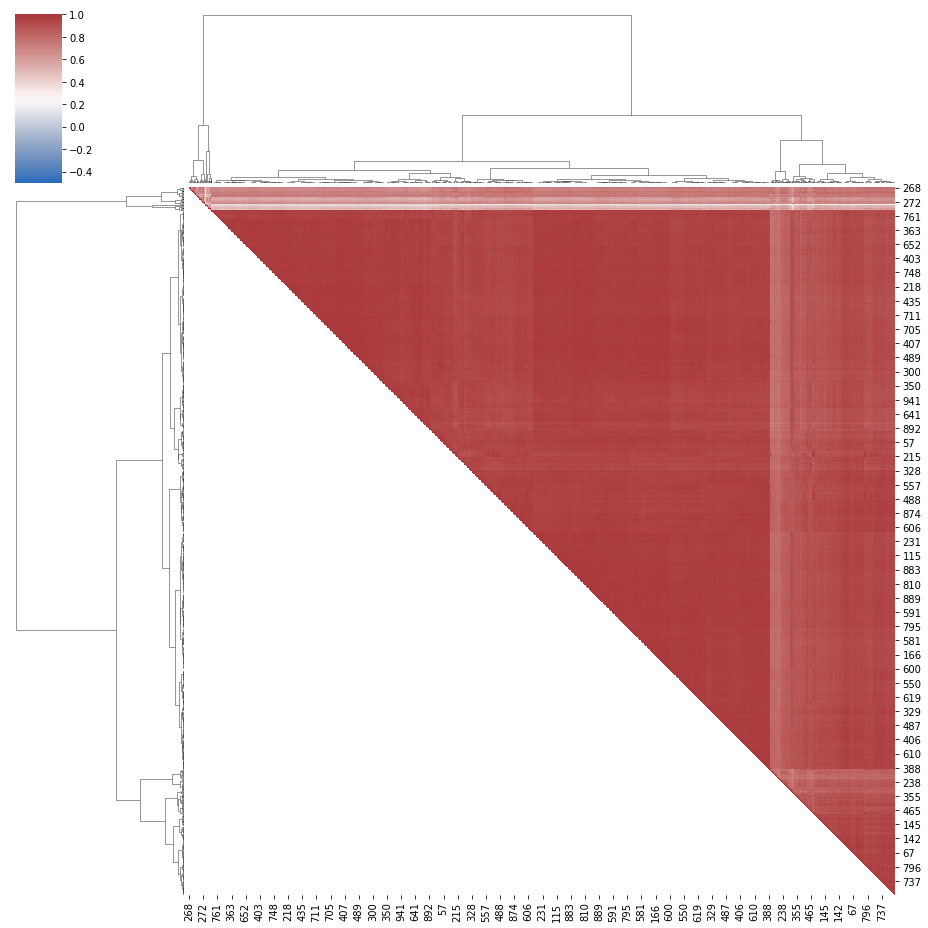

In [26]:
result_dir = "../../results/"

def plot_correlationmatrix_dendogram(corr, img_name, ticks, method= 'ward', div=False):

    df = pd.DataFrame(corr)
    
    # group the videos
    links = linkage(df, method=method,)
    order = leaves_list(links)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    
    for i in range(nbVideos):
        for j in range(nbVideos):
            if i>j:
                mask[order[i]][order[j]] = True
    
    sns.clustermap(df, cmap="vlag", mask=mask, method=method,
                   linewidths=0, figsize=(13, 13), cbar_kws={"ticks":ticks}, vmin =-0.5)
    plt.savefig(result_dir+img_name)
    plt.show()
    
    return cut_tree(links, n_clusters = 3)

group_no_ordered = plot_correlationmatrix_dendogram(corrSpearman, 
                                 "corrmatrix-ugc-dendo-Spearman-" + predDimension + ".png",
                                 [k/5 for k in np.arange(-10,10,1)], method='ward')

In [8]:
map_group = [1, 2, 0]

def f(gr):
    return map_group[int(gr)]

groups = np.array([*map(f, group_no_ordered)],int)

sum(groups==0)
sum(groups==1)
sum(groups==2)

751

In [9]:
corrDescription = [corrSpearman[i][j] for i in range(nbVideos) for j in range(nbVideos) if i >j]
pd.Series(corrDescription).describe()

count    450775.000000
mean          0.923431
std           0.094035
min           0.022957
25%           0.918656
50%           0.954455
75%           0.972099
max           0.996395
dtype: float64

In [10]:
def plot_simple_correlationmatrix_dendogram(corr, img_name, ticks, id_names, method='ward'):

    df = pd.DataFrame(corr)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    
    for i in range(shortnbVideos):
        for j in range(shortnbVideos):
            if i>j:
                mask[i][j] = True
    fig = plt.figure(figsize=(10, 8.5))
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(df, cmap="vlag", mask=mask,
               linewidths=.75, cbar_kws={"ticks":ticks})
    plt.yticks(np.arange(0,len(id_names),1)+0.5, id_names)
    plt.xticks(np.arange(0,len(id_names),1)+0.5, id_names)
    plt.savefig(result_dir+img_name)
    plt.show()

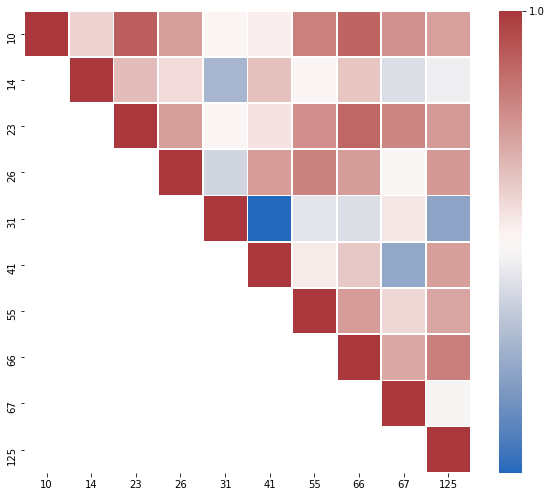

In [11]:
id_short = [10, 14, 23, 26, 31, 41, 55, 66, 67, 125]
short_v_names = [v_names[k] for k in id_short]

shortlistVideo = []
for v in short_v_names:
    data = pd.read_table(res_dir+v, delimiter = ',')
    data['etime'] = [*map(elapsedtime_to_sec, data['elapsedtime'])]
    shortlistVideo.append(data)
    
shortnbVideos = len(shortlistVideo)

shortcorrSpearman= [[0 for x in range(shortnbVideos)] for y in range(shortnbVideos)]


for i in range(shortnbVideos):
    for j in range(shortnbVideos):
        if (i == j):
            shortcorrSpearman[i][j] = 1
        else:
            shortcorrSpearman[i][j] = sc.spearmanr(listVideo[id_short[i]][predDimension],listVideo[id_short[j]][predDimension]).correlation

plot_simple_correlationmatrix_dendogram(shortcorrSpearman, 
                     "corrmatrix-ugc-dendo-Spearman-short-" + predDimension + ".png", 
                     [k/5 for k in np.arange(-10,10,1)],
                                      id_short)

# RQ1-2

### Shortlist

In [12]:
id_short

[10, 14, 23, 26, 31, 41, 55, 66, 67, 125]

In [13]:
shortlistVideo[0] # video 10

,configurationID,cabac,ref,deblock,analyse,me,subme,mixed_ref,me_range,trellis,...,usertime,systemtime,elapsedtime,cpu,frames,fps,kbs,ssim,ssimdb,etime
0,1,0,1,0:0:0,0:0,dia,0,0,16,0,...,8.69,0.92,0:01.75,549,480,379.18,7675.34,NaN,NaN,1.75
1,101,1,2,1:0:0,0x3:0x113,hex,6,1,16,1,...,29.88,1.56,0:04.08,770,480,137.35,2722.25,NaN,NaN,4.08
2,102,1,2,1:0:0,0x3:0x113,hex,6,1,16,1,...,26.00,1.58,0:03.04,905,480,194.98,3179.35,NaN,NaN,3.04
3,103,1,2,0:0:0,0x3:0x3,umh,6,1,16,1,...,32.80,1.37,0:02.89,1181,480,206.63,3142.93,NaN,NaN,2.89
4,104,1,16,1:0:0,0x3:0x113,hex,6,1,24,1,...,39.70,1.41,0:03.29,1249,480,176.69,2579.38,NaN,NaN,3.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,97,1,2,1:0:0,0x3:0x113,hex,4,1,16,0,...,24.80,1.67,0:03.55,745,480,160.70,2747.42,NaN,NaN,3.55
197,98,1,2,0:0:0,0x3:0x113,hex,4,0,24,0,...,21.85,1.59,0:03.06,766,480,192.69,2805.80,NaN,NaN,3.06
198,99,1,5,1:0:0,0x3:0x113,hex,6,1,16,1,...,32.95,1.42,0:03.45,996,480,166.61,2582.37,NaN,NaN,3.45
199,100,0,3,0:0:0,0x113:0x113,hex,6,1,16,1,...,26.68,1.56,0:02.76,1022,480,218.91,3379.49,NaN,NaN,2.76


In [14]:
listFeatures = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", "b_adapt", "direct", "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", "mbtree", "qpmax", "aq-mode"]

to_keep = [k for k in listFeatures]
to_keep.append(predDimension)

categorial = ['analyse', 'me', 'direct']

def compute_Importances(listVid, id_short=None):
    
    if not id_short:
        id_short = np.arange(0,len(listVid),1)
        
    listImportances = []

    for id_video in range(len(listVid)):

        df = listVid[id_video][to_keep].replace(to_replace ="None",value='0')

        df['deblock'] =[int(val[0]) for val in df['deblock']]

        for col in df.columns:
            if col not in categorial:
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col

        clf = RandomForestRegressor(n_estimators=200)
        X = df.drop([predDimension],axis=1)
        y = df[predDimension]
        clf.fit(X,y)

        listImportances.append(clf.feature_importances_)

    res = pd.DataFrame({'features' : listFeatures})

    cs = 100

    for id_video in range(len(listImportances)):
        res['video_'+str(id_short[id_video])] = np.round(cs*listImportances[id_video])/cs

    res = res.set_index('features').transpose().drop(['open_gop','qpmax'],axis=1)
    return res

res = compute_Importances(shortlistVideo, id_short)
res.to_csv("../../results/shortlist_features_importances"+predDimension+".csv")

### Boxplot

In [15]:
res = compute_Importances(listVideo)

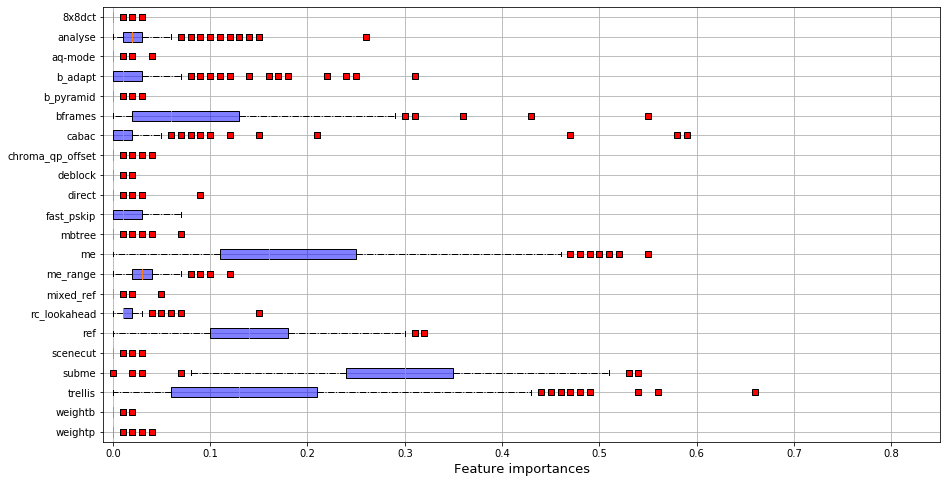

In [16]:
def boxplot_imp(res, xlim = None, criteria = 'max', name = None):
    if criteria == 'max':
        listImp = [(np.percentile(res[col],75), res[col], col) 
                   for col in res.columns]
        listImp.sort(key=lambda tup: tup[0])
    elif criteria == 'range':
        listImp = [(np.abs(np.percentile(res[col],75)-np.percentile(res[col],25)),res[col], col) 
                   for col in res.columns]
        listImp.sort(key=lambda tup: tup[0])
    elif criteria == 'name':
        listImp = [(np.abs(np.percentile(res[col],75)-np.percentile(res[col],25)),res[col], col) 
                   for col in res.columns]
        listImp.sort(key=lambda tup: tup[2], reverse=True)

    red_square = dict(markerfacecolor='r', marker='s')
    plt.figure(figsize=(15,8))
    plt.grid()
    plt.boxplot([l[1] for l in listImp], flierprops=red_square, 
              vert=False, patch_artist=True, #widths=0.25,
              boxprops=dict(facecolor=(0,0,1,0.5),linewidth=1,edgecolor='k'),
              whiskerprops = dict(linestyle='-.',linewidth=1.0, color='black'))
    plt.xlabel('Feature importances',size=13)
    if xlim:
        plt.xlim(xlim)
    plt.yticks(range(1, len(listImp) + 1), [l[2] for l in listImp])
    if name:
        plt.savefig(name)
    plt.show()
    
boxplot_imp(res, xlim = (-0.01,0.85),
            criteria = 'name', 
            name = "../../results/boxplot_features_imp_rf_"+predDimension+".png")

### Regression

In [17]:
def compute_poly(listVid, id_short=None):
    
    if not id_short:
        id_short = np.arange(0,len(listVid),1)
    
    listImportances = []
    
    #listFeatures = ['subme','aq-mode','mbtree','cabac']
    
    to_keep = [k for k in listFeatures]
    to_keep.append(predDimension)
    
    names = listFeatures
    final_names = []
    final_names.append('constant')
    for n in names:
        final_names.append(n)
    for n1 in range(len(names)):
        for n2 in range(len(names)):
            if n1>=n2:
                final_names.append(str(names[n1])+'*'+str(names[n2]))
    
    for id_video in range(len(listVid)):

        df = listVid[id_video][to_keep].replace(to_replace ="None",value='0')
        df['deblock'] =[int(val[0]) for val in df['deblock']]

        for col in df.columns:
            if col not in categorial:
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col

        clf = LinearRegression()
        X = df.drop([predDimension],axis=1)

        y = df[predDimension]
        #poly = PolynomialFeatures(degree=1, interaction_only = False, include_bias = True)    
        #X_interact = pd.DataFrame(poly.fit_transform(X))#, columns=final_names)
        #kept_names = ['subme','aq-mode','mbtree','cabac','cabac*mbtree','aq-mode*subme','cabac*subme']
        clf.fit(X,y)
        listImportances.append(clf.coef_)

    res = pd.DataFrame({'features' : listFeatures})

    cs = 100

    for id_video in range(len(listImportances)):
        res['video_'+str(id_short[id_video])] = np.round(cs*listImportances[id_video])/cs

    res = res.set_index('features').drop(['open_gop','qpmax']).transpose()
    return res

res = compute_poly(listVideo)
res.to_csv("../../results/list_features_importances_poly_"+predDimension+".csv")
res

features,cabac,ref,deblock,analyse,me,subme,mixed_ref,me_range,trellis,8x8dct,...,bframes,b_pyramid,b_adapt,direct,weightb,weightp,scenecut,rc_lookahead,mbtree,aq-mode
video_0,-0.02,0.10,0.02,0.01,0.11,0.04,-0.16,0.12,0.09,0.03,...,0.44,0.12,0.30,-0.13,-0.38,-0.02,0.03,0.02,0.08,0.00
video_1,-0.05,0.28,-0.02,0.04,0.21,0.15,-0.13,0.10,0.08,-0.01,...,0.35,0.16,0.13,-0.08,-0.31,-0.10,0.09,0.01,-0.00,-0.00
video_2,-0.08,0.26,-0.01,0.06,0.24,0.12,-0.13,0.14,0.10,-0.03,...,0.26,0.22,0.02,-0.12,-0.26,-0.07,0.11,0.01,0.01,-0.00
video_3,-0.05,0.27,-0.01,0.04,0.21,0.13,-0.15,0.13,0.09,-0.02,...,0.30,0.17,0.12,-0.11,-0.27,-0.08,0.07,0.01,0.02,-0.01
video_4,-0.09,0.28,-0.01,0.03,0.17,0.16,-0.15,0.14,0.15,-0.01,...,0.26,0.19,0.11,-0.09,-0.29,-0.10,0.09,0.00,0.03,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
video_945,-0.11,0.28,-0.00,0.05,0.18,0.17,-0.14,0.14,0.16,-0.03,...,0.24,0.19,0.09,-0.09,-0.29,-0.12,0.10,0.00,-0.00,0.00
video_946,-0.12,0.30,-0.04,0.04,0.19,0.19,-0.11,0.11,0.20,0.00,...,0.23,0.17,0.02,-0.09,-0.24,-0.13,0.13,0.01,0.02,-0.03
video_947,-0.06,0.27,-0.02,0.04,0.21,0.15,-0.13,0.12,0.12,-0.03,...,0.28,0.16,0.13,-0.11,-0.28,-0.10,0.09,0.02,0.01,0.01
video_948,-0.03,0.25,-0.01,0.06,0.26,0.18,-0.13,0.12,0.06,-0.05,...,0.27,0.15,-0.02,-0.12,-0.22,-0.00,0.14,0.02,0.02,0.02


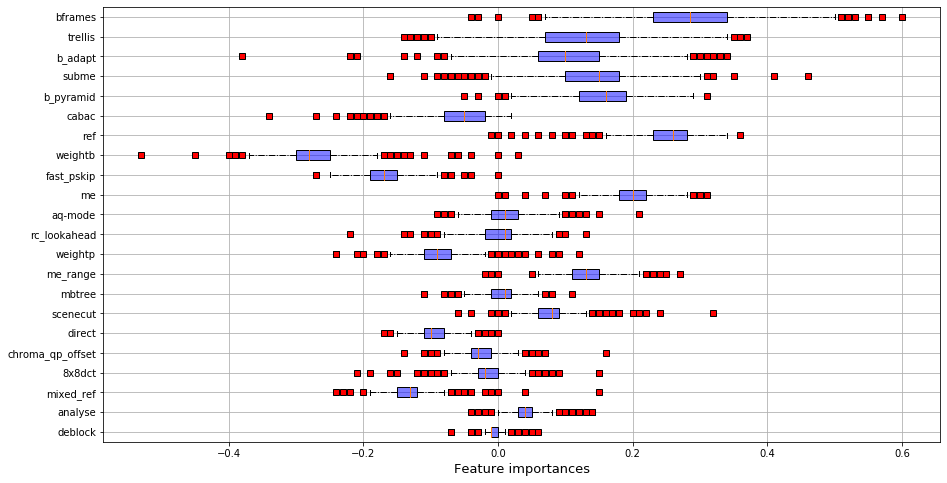

In [18]:
boxplot_imp(res, criteria ='range', name ="../../results/boxplot_features_imp_linear_"+predDimension+".png")

# RQ2

## RQ2.1 - Group of performances

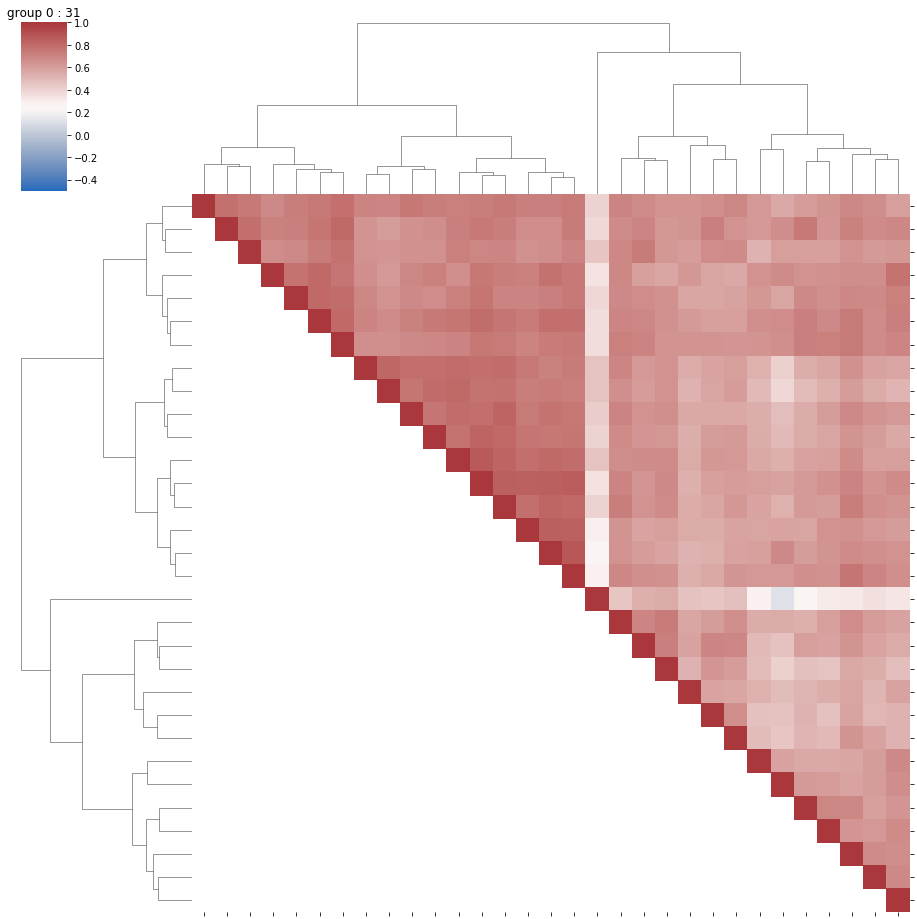

count    465.000000
mean       0.635606
std        0.110522
min        0.121200
25%        0.579844
50%        0.646696
75%        0.706161
max        0.879076
dtype: float64


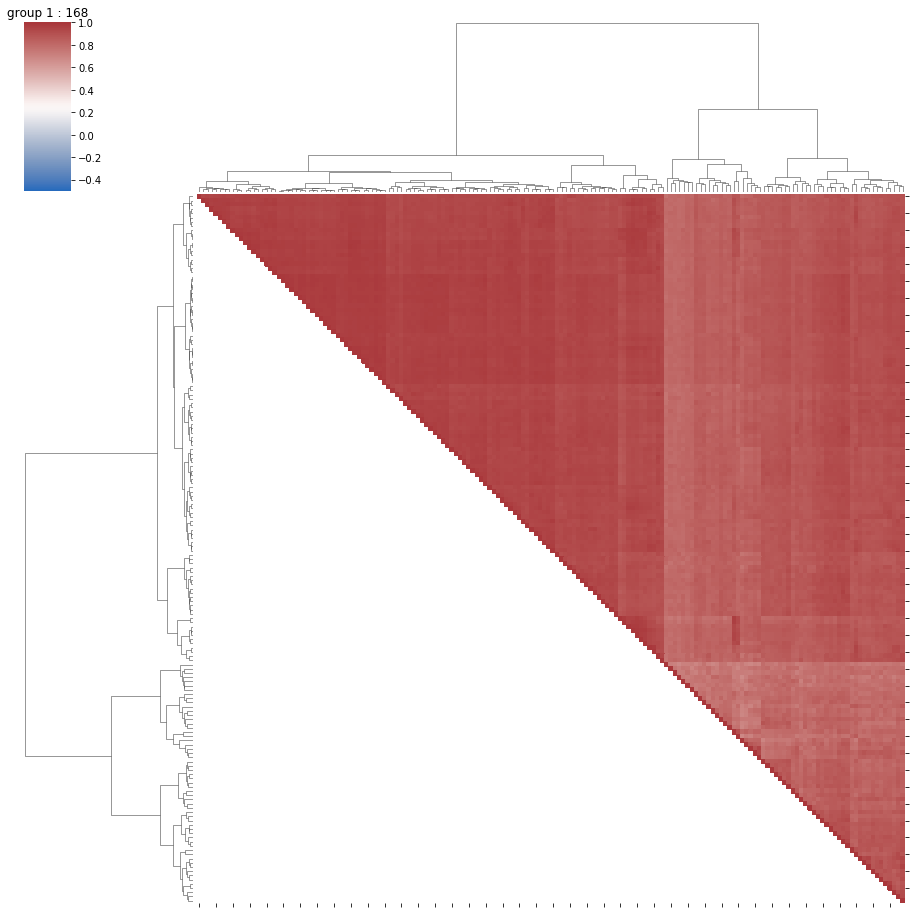

count    14028.000000
mean         0.897449
std          0.056232
min          0.676689
25%          0.857975
50%          0.907957
75%          0.944213
max          0.991528
dtype: float64


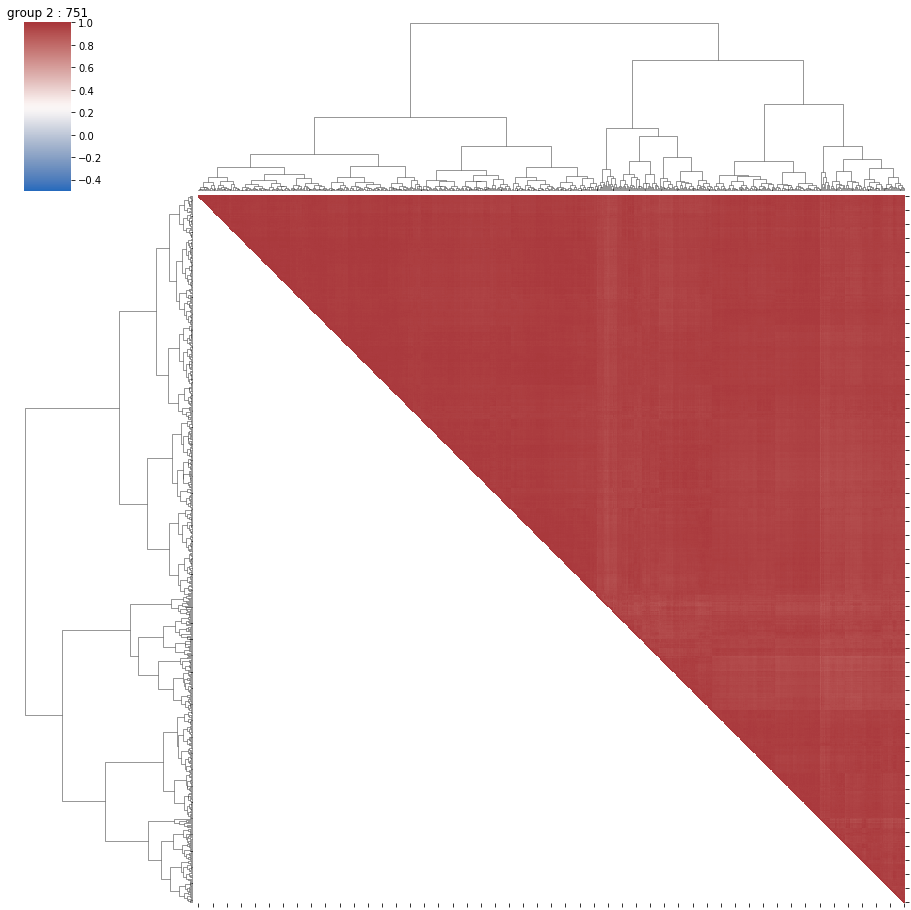

count    281625.000000
mean          0.964780
std           0.016533
min           0.853005
25%           0.955281
50%           0.968023
75%           0.977356
max           0.996395
dtype: float64


In [19]:
def plot_corr_matrix(corr, method = 'ward', title=''):

    df = pd.DataFrame(corr)
    
    links = linkage(df, method=method,)
    order = leaves_list(links)
    
    mask = np.zeros_like(corr, dtype=np.bool)
    
    for i in range(len(corr)):
        for j in range(len(corr)):
            if i>j:
                mask[order[i]][order[j]] = True
    
    g = sns.clustermap(df, cmap="vlag", mask=mask, method=method,
                   linewidths=0, figsize=(13, 13), vmin=-0.5)
    g.ax_heatmap.set_yticklabels([])
    g.ax_heatmap.set_xticklabels([])
    plt.title(title)
    plt.show()
    
    corrDescription = [corr[i][j] for i in range(len(corr)) for j in range(len(corr)) if i >j]
    return pd.Series(corrDescription).describe()

def plot_group(group_index):
    ind = np.array([k for k in range(len(corrSpearman)) if groups[k] == group_index], dtype=int)
    group = np.copy([[corrSpearman[k][j] for j in ind] for k in ind])
    print(plot_corr_matrix(group,title="group "+str(group_index)+" : "+str(len(group))))

for i in range(3):
    plot_group(i)

## Summary per group

In [20]:
meta = pd.read_csv("../data/ugc_meta/all_features.csv").set_index('FILENAME')
meta['category']=[str(meta.index[i]).split('_')[0] for i in range(meta.shape[0])]
del meta['NOISE_DMOS']
meta = meta.fillna(0)
cat_tab = pd.Series(meta['category'].values).unique()
meta['video_category'] = [np.where(cat_tab==meta['category'][i])[0][0] for i in range(len(meta['category']))]
del meta['category']
for col in meta.columns:#[:len(meta.columns)-1]:
    inter = np.array(meta[col],float)
    meta[col] = (inter-np.mean(inter))/np.std(inter)
perf = pd.DataFrame({'FILENAME': np.array([v_names[k][:-4] for k in range(len(v_names))])[1:],
              'perf_group' : np.array([k for k in groups])[1:]}).set_index('FILENAME')
meta_perf = perf.join(meta)
meta_perf

,perf_group,SLEEQ_DMOS,BANDING_DMOS,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,video_category
FILENAME,,,,,,,,,,
Animation_1080P-05f8,2,0.843640,0.742227,0.380890,0.330315,-0.147062,0.443113,2.546727,2.208462,-1.618994
Animation_1080P-0c4f,2,-0.656518,-0.377309,0.380890,0.330315,0.422696,-0.963894,1.055535,-1.232585,-1.618994
Animation_1080P-0cdf,2,-0.294941,-0.059125,0.380890,0.330315,-0.028411,0.429840,-0.102867,-0.448165,-1.618994
Animation_1080P-18f5,2,-0.479576,-0.377309,0.380890,0.330315,1.289667,-0.959469,-0.050889,0.193239,-1.618994
Animation_1080P-209f,2,6.282675,-0.377309,0.380890,0.330315,2.315231,-1.512538,-0.622865,-1.232585,-1.618994
...,...,...,...,...,...,...,...,...,...,...
Vlog_720P-561e,2,-0.679597,-0.377309,-0.241046,-0.334452,0.979531,-1.415198,-0.652628,0.457602,1.494285
Vlog_720P-5d08,2,-0.679597,-0.377309,-0.773579,-0.334452,3.258561,-0.304636,-0.437382,-0.157800,1.494285
Vlog_720P-60f8,2,0.443598,0.624381,-0.241046,-0.334452,0.234735,-0.043587,-0.364052,-0.149132,1.494285


In [21]:
meta_perf['str_video_cat'] = [str(meta_perf.index[i]).split('_')[0] for i in range(meta_perf.shape[0])]
total_cat = meta_perf.groupby('str_video_cat').count()['perf_group']
group_perf = np.array([gr for gr in groups])
group_perf

array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2,

In [22]:
def summary_group(id_group):
            
    id_list = [i for i in range(len(listVideo)) if group_perf[i]==id_group]
    v_names_group = [v_names[i][:-4] for i in range(len(v_names)) if i in id_list]
    listVideoGroup = [listVideo[i] for i in range(len(listVideo)) if i in id_list]
    
    print('Group '+str(id_group)+' : '+str(len(listVideoGroup))+' videos!')
    
    print('\n')

    # features importances
    boxplot_imp(compute_Importances(listVideoGroup), criteria = 'name', xlim= (0, 1),
               name ="../../results/boxplot_imp_group"+str(id_group)+".png")

    # features effects
    boxplot_imp(compute_poly(listVideoGroup), criteria = 'name', xlim = (-1, 1),
               name ="../../results/boxplot_effect_group"+str(id_group)+".png")

    print('\n')

    interest_var = ['cpu', 'etime', 'fps', 'kbs', 'size']

    for iv in interest_var:
        pred = [np.mean(lv[iv]) for lv in listVideoGroup]
        print('Mean '+iv+' in the group: '+str(np.round(np.mean(pred),1)))

    print('\n')

    # percentage of the videos present in the group par category

    meta_perf_group = meta_perf.query('perf_group=='+str(id_group))
    meta_perf_group['str_video_cat'] = [str(meta_perf_group.index[i]).split('_')[0] for i in range(meta_perf_group.shape[0])]
    val_group = meta_perf_group.groupby('str_video_cat').count()['perf_group']
    df_res_cat_group = pd.DataFrame({'val': val_group, 'total': total_cat})
    print(df_res_cat_group['val']/df_res_cat_group['total'])

    print('\n')

    # Mean of the videos of the group per properties

    for col in meta_perf_group.columns:
        if col not in ['str_video_cat', 'video_category']:
            print('Mean '+col+' : '+str(meta_perf_group[col].mean()))

    print('\n')

    corrGroup = np.array([corrSpearman[i][j] for i in range(len(corrSpearman)) if i in id_list 
                 for j in range(len(corrSpearman)) if j in id_list],float)

    print("Correlations intra-group: \n" + str(pd.Series(corrGroup).describe().iloc[[1,5]])+'\n')

Group 0 : 31 videos!




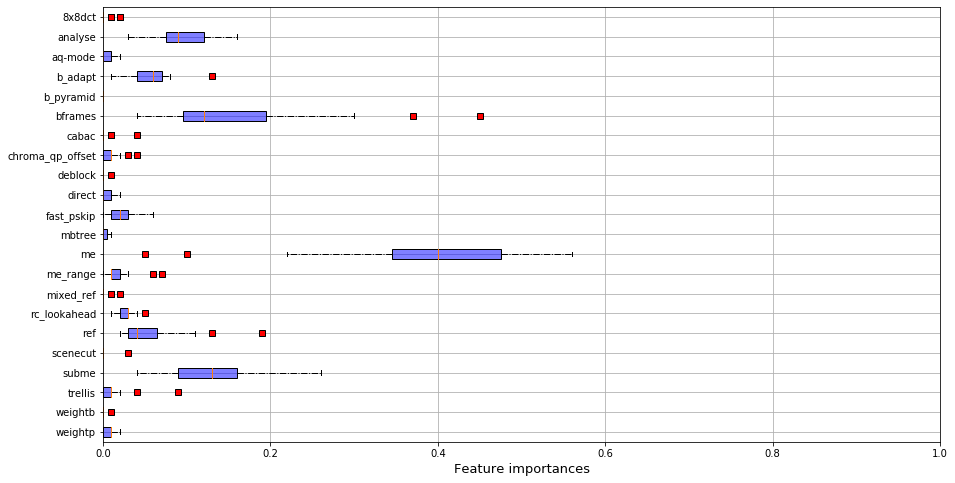

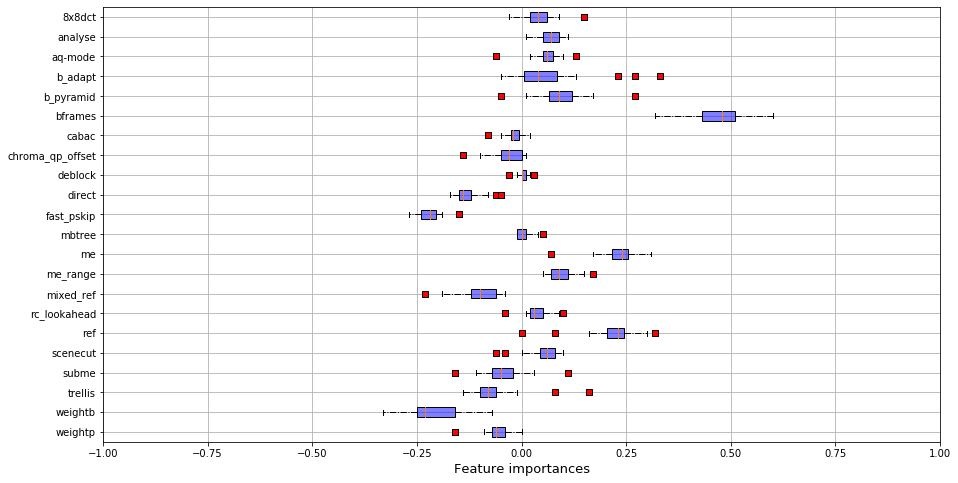



Mean cpu in the group: 619.9
Mean etime in the group: 98.3
Mean fps in the group: 35.1
Mean kbs in the group: 22588.0
Mean size in the group: 56460239.9


Animation              NaN
CoverSong              NaN
Gaming                 NaN
HDR               0.557692
HowTo                  NaN
Lecture                NaN
LiveMusic              NaN
LyricVideo             NaN
MusicVideo             NaN
NewsClip               NaN
Sports                 NaN
TelevisionClip         NaN
VR                0.014286
VerticalVideo     0.013333
Vlog                   NaN
dtype: float64


Mean perf_group : 0.0
Mean SLEEQ_DMOS : 0.26343012532687715
Mean BANDING_DMOS : -0.041258317690693165
Mean WIDTH : 1.7957940639128431
Mean HEIGHT : 1.8676186590659705
Mean SPATIAL_COMPLEXITY : -0.7090504747427141
Mean TEMPORAL_COMPLEXITY : -0.17960648222014755
Mean CHUNK_COMPLEXITY_VARIATION : -0.39698798622016795
Mean COLOR_COMPLEXITY : 0.2722262404389464


Correlations intra-group: 
mean    0.647361
50%     0.651601

/home/llesoil/anaconda3/envs/x264/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
summary_group(0)

Group 1 : 168 videos!




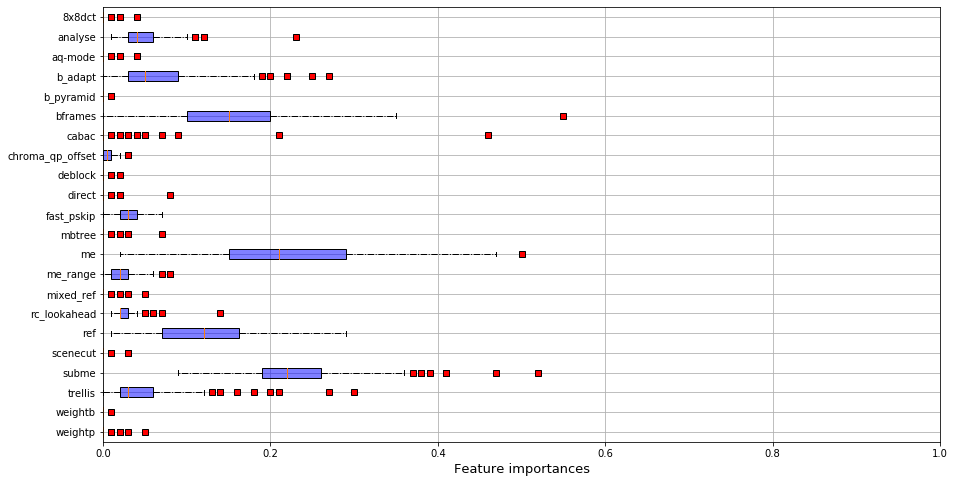

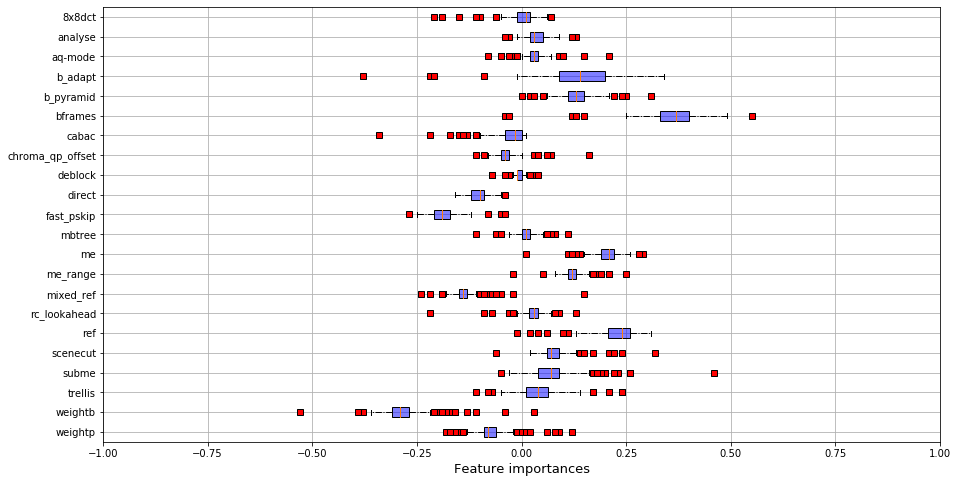



Mean cpu in the group: 1215.7
Mean etime in the group: 22.4
Mean fps in the group: 138.9
Mean kbs in the group: 21236.7
Mean size in the group: 52228066.2


Animation         0.081395
CoverSong              NaN
Gaming            0.181818
HDR               0.442308
HowTo             0.103448
Lecture           0.057692
LiveMusic         0.067568
LyricVideo        0.181818
MusicVideo             NaN
NewsClip               NaN
Sports            0.100000
TelevisionClip    0.036364
VR                0.185714
VerticalVideo     0.240000
Vlog              0.348101
dtype: float64


Mean perf_group : 1.0
Mean SLEEQ_DMOS : -0.07603302366222811
Mean BANDING_DMOS : 0.18997423123924528
Mean WIDTH : 1.241800927428602
Mean HEIGHT : 1.3356701827463904
Mean SPATIAL_COMPLEXITY : -0.7596378992848146
Mean TEMPORAL_COMPLEXITY : 0.2955135818524045
Mean CHUNK_COMPLEXITY_VARIATION : -0.29901175798533086
Mean COLOR_COMPLEXITY : -0.06624471131934162




/home/llesoil/anaconda3/envs/x264/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Correlations intra-group: 
mean    0.898060
50%     0.908528
dtype: float64



In [24]:
summary_group(1)

Group 2 : 751 videos!




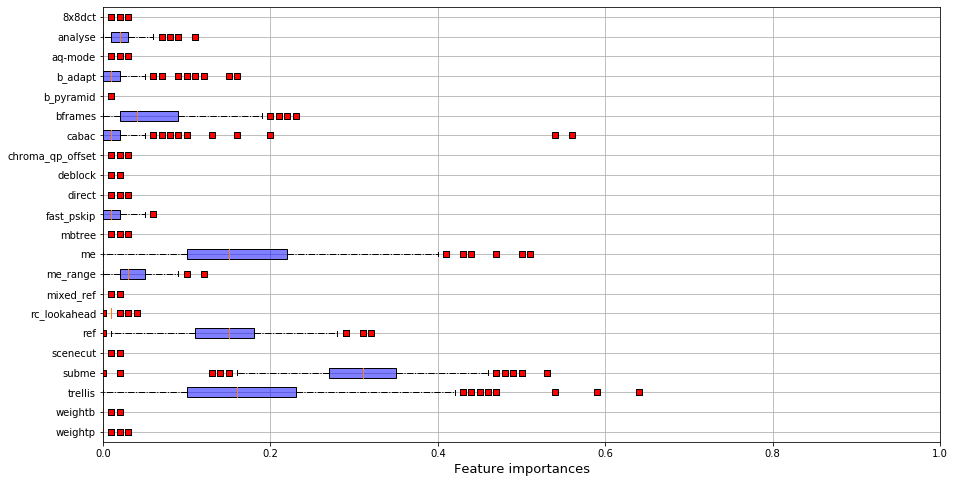

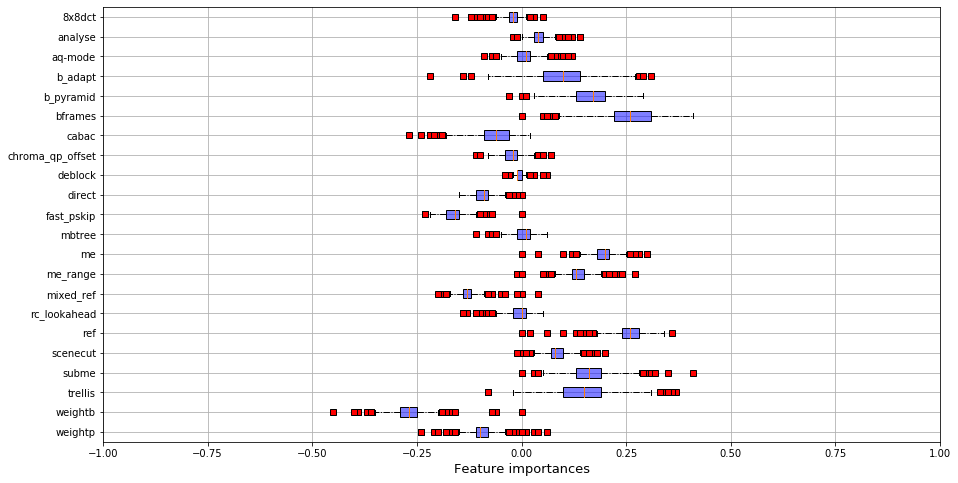



Mean cpu in the group: 916.9
Mean etime in the group: 5.5
Mean fps in the group: 497.6
Mean kbs in the group: 6977.0
Mean size in the group: 17292549.3


Animation         0.918605
CoverSong         1.000000
Gaming            0.818182
HDR                    NaN
HowTo             0.896552
Lecture           0.942308
LiveMusic         0.932432
LyricVideo        0.818182
MusicVideo        1.000000
NewsClip          1.000000
Sports            0.900000
TelevisionClip    0.963636
VR                0.800000
VerticalVideo     0.746667
Vlog              0.651899
dtype: float64


Mean perf_group : 2.0
Mean SLEEQ_DMOS : -0.015120858265081628
Mean BANDING_DMOS : -0.011453381663218349
Mean WIDTH : -0.30999935703592946
Mean HEIGHT : -0.32090882085145583
Mean SPATIAL_COMPLEXITY : 0.1602213211949431
Mean TEMPORAL_COMPLEXITY : -0.058610654133058486
Mean CHUNK_COMPLEXITY_VARIATION : 0.11526256612951781
Mean COLOR_COMPLEXITY : 0.025218700683890097




/home/llesoil/anaconda3/envs/x264/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Correlations intra-group: 
mean    0.964827
50%     0.968049
dtype: float64



In [25]:
summary_group(2)

In [88]:
group_perf
id_list_0 = [i for i in range(len(listVideo)) if group_perf[i]==0]
id_list_1 = [i for i in range(len(listVideo)) if group_perf[i]==1]
id_list_2 = [i for i in range(len(listVideo)) if group_perf[i]==2]

res = np.zeros(9).reshape(3,3)

tab = []
for id0 in id_list_0:
    for id1 in id_list_1:
        tab.append(corrSpearman[id0][id1])
res[0][1] = np.mean(tab)

for id0 in id_list_0:
    for id2 in id_list_2:
        tab.append(corrSpearman[id0][id2])
res[0][2] = np.mean(tab)

for id1 in id_list_1:
    for id2 in id_list_2:
        tab.append(corrSpearman[id1][id2])
res[1][2] = np.mean(tab)

print(res)

res_med = np.zeros(9).reshape(3,3)

tab = []
for id0 in id_list_0:
    for id1 in id_list_1:
        tab.append(corrSpearman[id0][id1])
res_med[0][1] = np.median(tab)

for id0 in id_list_0:
    for id2 in id_list_2:
        tab.append(corrSpearman[id0][id2])
res_med[0][2] = np.median(tab)

for id1 in id_list_1:
    for id2 in id_list_2:
        tab.append(corrSpearman[id1][id2])
res_med[1][2] = np.median(tab)

res_med

[[0.         0.10236622 0.39042802]
 [0.         0.         0.4402605 ]
 [0.         0.         0.        ]]


array([[0.        , 0.10941812, 0.42301883],
       [0.        , 0.        , 0.47749604],
       [0.        , 0.        , 0.        ]])

## RQ2.2 - Group classification

In [150]:
if 'str_video_cat' in meta_perf.columns:
    del meta_perf['str_video_cat']

accuracy = []

nbLaunches =10
for i in range(nbLaunches):
    X = np.array(meta_perf[[k for k in meta_perf.columns if k !='perf_group']], float)
    y = np.array(meta_perf['perf_group'], float)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)


    conf = pd.crosstab(y_pred, y_test)#, colnames=[1,2,3], rownames=[1,2,3])
    val = np.sum(np.diag(conf))/len(y_test)
    accuracy.append(val)
    print('Test accuracy : '+ str(val))
    conf.columns = pd.Int64Index([1,2,3], dtype='int64', name='Observed')
    conf.index = pd.Int64Index([1,2,3], dtype='int64', name='Predicted')
    conf
print(np.mean(accuracy))
conf

Test accuracy : 0.772020725388601
Test accuracy : 0.689119170984456
Test accuracy : 0.7461139896373057
Test accuracy : 0.7305699481865285
Test accuracy : 0.7305699481865285
Test accuracy : 0.6735751295336787
Test accuracy : 0.7150259067357513
Test accuracy : 0.7357512953367875
Test accuracy : 0.7305699481865285
Test accuracy : 0.7409326424870466
0.7264248704663212


Observed,1,2,3
Predicted,,,
1,39,0,11
2,0,20,11
3,11,17,84


In [97]:
meta_perf

,perf_group,SLEEQ_DMOS,BANDING_DMOS,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,video_category
FILENAME,,,,,,,,,,
Animation_1080P-05f8,2,0.843640,0.742227,0.380890,0.330315,-0.147062,0.443113,2.546727,2.208462,-1.618994
Animation_1080P-0c4f,2,-0.656518,-0.377309,0.380890,0.330315,0.422696,-0.963894,1.055535,-1.232585,-1.618994
Animation_1080P-0cdf,0,-0.294941,-0.059125,0.380890,0.330315,-0.028411,0.429840,-0.102867,-0.448165,-1.618994
Animation_1080P-18f5,0,-0.479576,-0.377309,0.380890,0.330315,1.289667,-0.959469,-0.050889,0.193239,-1.618994
Animation_1080P-209f,2,6.282675,-0.377309,0.380890,0.330315,2.315231,-1.512538,-0.622865,-1.232585,-1.618994
...,...,...,...,...,...,...,...,...,...,...
Vlog_720P-561e,2,-0.679597,-0.377309,-0.241046,-0.334452,0.979531,-1.415198,-0.652628,0.457602,1.494285
Vlog_720P-5d08,0,-0.679597,-0.377309,-0.773579,-0.334452,3.258561,-0.304636,-0.437382,-0.157800,1.494285
Vlog_720P-60f8,0,0.443598,0.624381,-0.241046,-0.334452,0.234735,-0.043587,-0.364052,-0.149132,1.494285


In [128]:
pd.DataFrame({'Random forest importance' : rf.feature_importances_,
              'name' : meta_perf.columns[1:]}).set_index('name')

,Random forest importance
name,
SLEEQ_DMOS,0.072091
BANDING_DMOS,0.046348
WIDTH,0.045705
HEIGHT,0.034997
SPATIAL_COMPLEXITY,0.289946
TEMPORAL_COMPLEXITY,0.209568
CHUNK_COMPLEXITY_VARIATION,0.148379
COLOR_COMPLEXITY,0.097515
video_category,0.055450


In [99]:
meta_perf.groupby(['perf_group']).mean()

,SLEEQ_DMOS,BANDING_DMOS,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,video_category
perf_group,,,,,,,,,
0,-0.078311,-0.229780,-0.116496,-0.135671,0.804723,0.289698,0.717640,-0.082420,0.043716
1,0.081870,0.122683,0.607173,0.537666,-0.891920,0.661285,-0.297182,0.188592,-0.008223
2,-0.071027,0.103646,-0.271269,-0.301448,-0.223278,-0.461625,-0.203138,0.048928,-0.386508
